In [1]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import statsmodels.graphics.api as smg

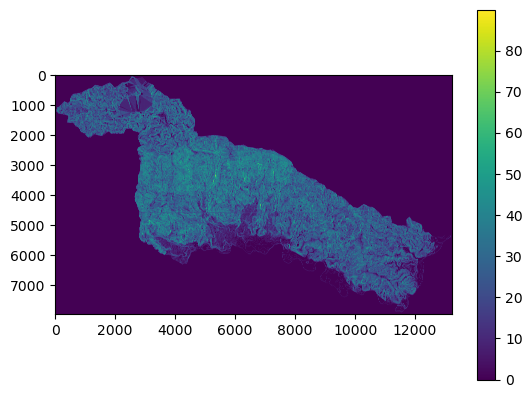

In [2]:
raster = rio.open(r'C:\Users\USUARIO\Desktop\Prueba\Lunes_noche\pendiente.tif')
pendiente=raster.read(1)
plt.imshow(pendiente)
plt.colorbar();

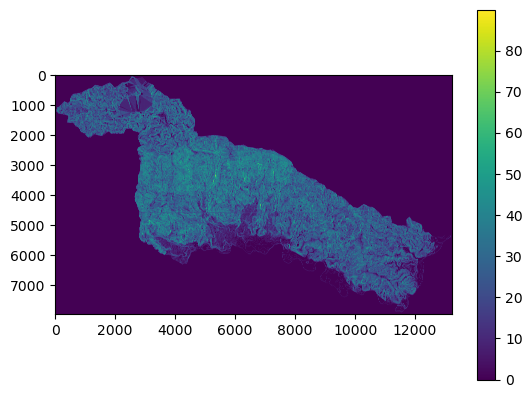

In [3]:
pendiente=np.where(pendiente<0,np.nan,pendiente)
plt.imshow(pendiente)
plt.colorbar();

In [4]:
type(pendiente)

numpy.ndarray

In [5]:
np.shape(pendiente)

(7969, 13231)

In [6]:
pendiente_vector=pendiente.ravel()  # para pasarlo a un vector
pendiente_vector_MenM=pendiente_vector[~np.isnan(pendiente_vector)] # para eliminar  del vector los datos NaN
pendiente_vector_MenM.shape # otra forma de saber las dimensiones

(105437839,)

Forma: (105437839,)


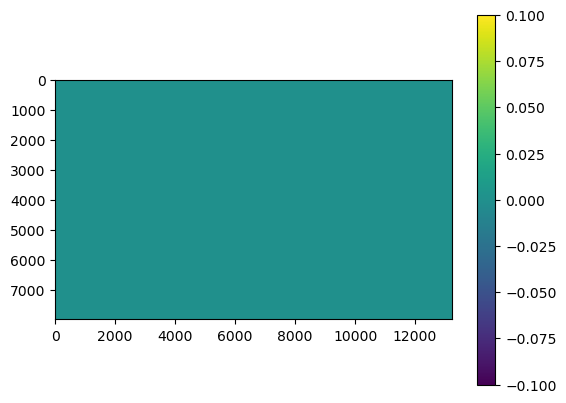

In [7]:
raster = rio.open(r'C:\Users\USUARIO\Desktop\Prueba\flujo\Flow_ac.tif')
flujo=raster.read(1)
flujo=np.where(flujo<0,np.nan,flujo)
flujo=np.where(flujo>50,0,flujo)
flujo_vector=flujo.ravel()
flujo_vector_MenM=flujo_vector[~np.isnan(flujo_vector)]
plt.imshow(flujo)
plt.colorbar()
flujo.shape
flujo_vector_MenM.shape
print('Forma:', flujo_vector_MenM.shape)

In [8]:
flujo_vector=flujo.ravel()  # para pasarlo a un vector
flujo_vector_MenM=flujo_vector[~np.isnan(flujo_vector)] # para eliminar  del vector los datos NaN
flujo_vector_MenM.shape # otra forma de saber las dimensiones

(105437839,)

Forma:  (7969, 13231)
Valores únicos:  [1.]


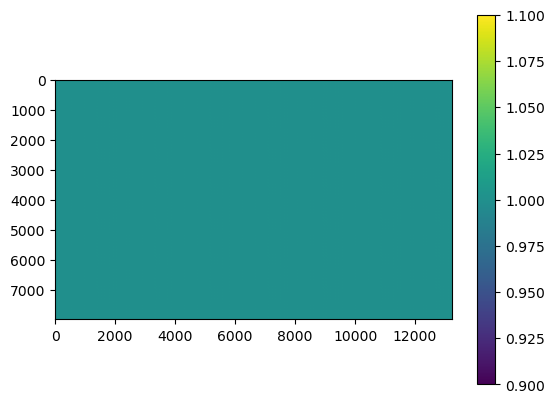

In [9]:
raster = rio.open(r'C:\Users\USUARIO\Desktop\Prueba\Lunes_noche\pendiente.tif')
msk=raster.read_masks(1)
msk=np.where(msk==0,np.nan,1)
plt.imshow(msk)
plt.colorbar();

print('Forma: ', msk.shape)
print('Valores únicos: ', np.unique(msk))

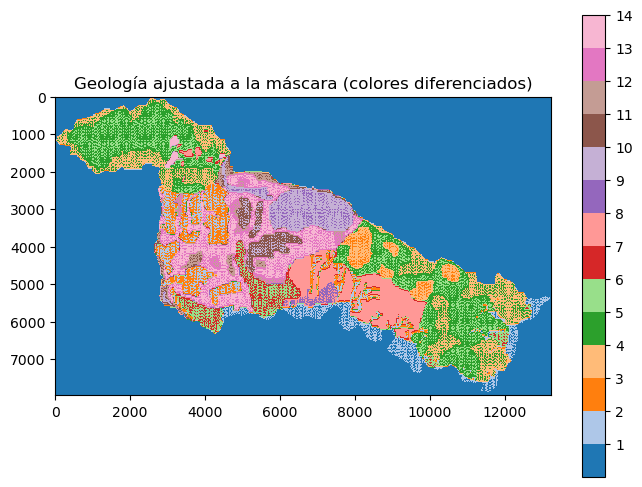

Forma: (7969, 13231)
Valores únicos: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


In [10]:
import rasterio as rio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns  # Para generar paleta automática si es necesario

# --- Abrir raster de geología ---
ruta_raster = r'C:\Users\USUARIO\Desktop\Prueba\geolo_pro\geologia_reproyectada.tif'
raster_geo = rio.open(ruta_raster)

# --- Remuestrear geología para que coincida con la máscara ---
geologia_resampleada = raster_geo.read(
    1,
    out_shape=(1, msk.shape[0], msk.shape[1]),  # 'msk' debe estar definido previamente
    resampling=Resampling.nearest
).squeeze()

# --- Aplicar la máscara ---
geologia_masc = geologia_resampleada * msk

# --- Obtener valores únicos, ignorando ceros ---
valores_unicos = np.unique(geologia_masc[geologia_masc != 0])

# --- Generar paleta de colores automática según número de clases ---
colores = sns.color_palette("tab20", len(valores_unicos)).as_hex()
cmap = ListedColormap(colores)

# --- Visualizar ---
plt.figure(figsize=(8, 6))
img = plt.imshow(geologia_masc, cmap=cmap)
plt.colorbar(img, ticks=valores_unicos)
plt.title('Geología ajustada a la máscara (colores diferenciados)')
plt.show()

# --- Imprimir información ---
print('Forma:', geologia_masc.shape)
print('Valores únicos:', valores_unicos)


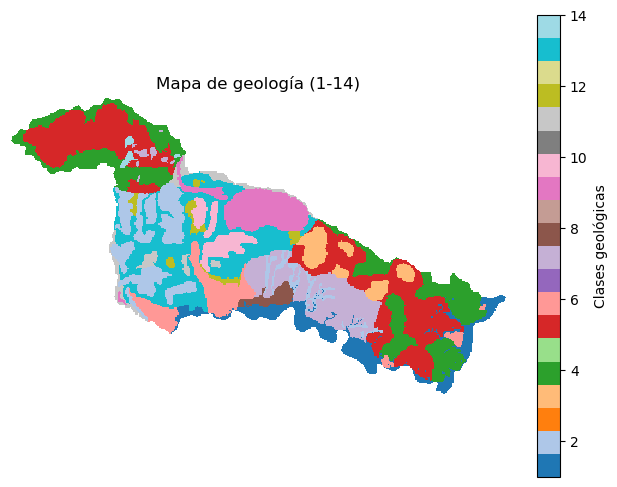

Forma del raster: (7969, 13231)
Cantidad de celdas válidas: 38438186
Valores únicos: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [11]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

# --- Ruta del raster ---
ruta = r'C:\Users\USUARIO\Desktop\Prueba\geolo_pro\geologia_reproyectada.tif'

# --- Abrir raster ---
with rio.open(ruta) as raster:
    geologia = raster.read(1)

# --- Limpiar valores fuera del rango válido (1-14) ---
geologia = np.where(geologia < 1, np.nan, geologia)
geologia = np.where(geologia > 14, np.nan, geologia)

# --- Vectorizar sin nan ---
geologia_vector = geologia.ravel()
geologia_vector_sin_nan = geologia_vector[~np.isnan(geologia_vector)]

# --- Visualizar ---
plt.figure(figsize=(8, 6))
img = plt.imshow(geologia, cmap='tab20', interpolation='none')
plt.colorbar(img, label='Clases geológicas')
plt.title('Mapa de geología (1-14)')
plt.axis('off')
plt.show()

# --- Información ---
print('Forma del raster:', geologia.shape)
print('Cantidad de celdas válidas:', geologia_vector_sin_nan.shape[0])
print('Valores únicos:', np.unique(geologia_vector_sin_nan.astype(int)))


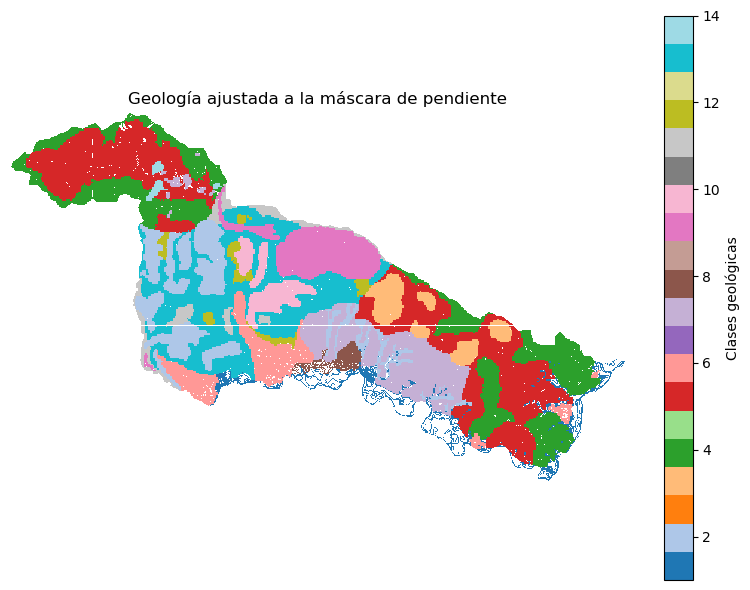

Forma final: (7969, 13231)
Valores únicos (1-14): [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [12]:
from rasterio.warp import reproject
import rasterio as rio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt

# --- Abrir raster de geología ---
with rio.open(r'C:\Users\USUARIO\Desktop\Prueba\geolo_pro\geologia_reproyectada.tif') as src_geo:
    geologia_data = src_geo.read(1)
    
    # Limpiar: dejar solo valores entre 1 y 14
    geologia_data = np.where((geologia_data >= 1) & (geologia_data <= 14), geologia_data, np.nan)

# --- Abrir raster de pendientes y preparar máscara ---
with rio.open(r'C:\Users\USUARIO\Desktop\Prueba\Lunes_noche\pendiente.tif') as src_mask:
    pendiente_data = src_mask.read(1)
    
    # Crear máscara binaria: 1 donde hay datos, NaN donde no
    msk = np.where(pendiente_data == 0, np.nan, 1)
    
    # Crear array vacío con forma del raster de pendiente
    geologia_resampled = np.empty((src_mask.height, src_mask.width), dtype=geologia_data.dtype)
    
    # Reproyectar raster de geología al sistema y forma del raster de pendiente
    with rio.open(r'C:\Users\USUARIO\Desktop\Prueba\geolo_pro\geologia_reproyectada.tif') as src_geo:
        reproject(
            source=geologia_data,
            destination=geologia_resampled,
            src_transform=src_geo.transform,
            src_crs=src_geo.crs,
            dst_transform=src_mask.transform,
            dst_crs=src_mask.crs,
            resampling=Resampling.nearest
        )

# --- Aplicar la máscara binaria ---
geologia_masked = geologia_resampled * msk

# --- Mostrar resultado ---
plt.figure(figsize=(8, 6))
img = plt.imshow(geologia_masked, cmap='tab20', interpolation='none')
plt.colorbar(img, label='Clases geológicas')
plt.title('Geología ajustada a la máscara de pendiente')
plt.axis('off')
plt.tight_layout()
plt.show()

# --- Información ---
valores_validos = np.unique(geologia_masked[~np.isnan(geologia_masked)].astype(int))
print('Forma final:', geologia_masked.shape)
print('Valores únicos (1-14):', valores_validos)


In [13]:
np.unique(geologia_masc)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14.])

In [14]:
valores = np.unique(geologia_masc)
valores_validos = valores[valores > 0]
print("Valores válidos:", valores_validos)


Valores válidos: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


In [15]:
# Diccionario de clases geológicas (leyenda)
leyenda = {
    1: "Suelo transportado aluvial de cauce activo",
    2: "Roca de calidad buena de tonalita del Batolito Antioqueño",
    3: "Suelo residual arcilloso de granodiorita del Batolito Antioqueño",
    4: "Suelo residual areno-gravoso de granodiorita del Batolito Antioqueño",
    5: "Suelo residual arcillo-limoso de granodiorita del Batolito Antioqueño",
    6: "Suelo transportado coluvial arcilloso",
    7: "Suelo transportado coluvial arcillo-limoso",
    8: "Suelo antrópico",
    9: "Roca de calidad mala de tonalita del Batolito Antioqueño",
    10: "Roca de calidad regular de tonalita del Batolito Antioqueño",
    11: "Suelo residual areno-gravoso de tonalita del Batolito Antioqueño",
    12: "Suelo residual arcilloso de tonalita del Batolito Antioqueño",
    13: "Suelo residual arcillo-limoso de tonalita del Batolito Antioqueño",
    14: "Roca de calidad mala de granodiorita del Batolito Antioqueño"
}

# Obtener valores únicos presentes en el raster (excluyendo 0 y NaN)
valores_presentes = np.unique(geologia_masc)
valores_presentes = valores_presentes[(valores_presentes > 0) & (~np.isnan(valores_presentes))]

# Imprimir clases presentes con sus nombres
print("Clases geológicas presentes en el raster:")
for val in valores_presentes.astype(int):
    nombre = leyenda.get(val, "Clase desconocida")
    print(f"{val}. {nombre}")


Clases geológicas presentes en el raster:
1. Suelo transportado aluvial de cauce activo
2. Roca de calidad buena de tonalita del Batolito Antioqueño
3. Suelo residual arcilloso de granodiorita del Batolito Antioqueño
4. Suelo residual areno-gravoso de granodiorita del Batolito Antioqueño
5. Suelo residual arcillo-limoso de granodiorita del Batolito Antioqueño
6. Suelo transportado coluvial arcilloso
7. Suelo transportado coluvial arcillo-limoso
8. Suelo antrópico
9. Roca de calidad mala de tonalita del Batolito Antioqueño
10. Roca de calidad regular de tonalita del Batolito Antioqueño
11. Suelo residual areno-gravoso de tonalita del Batolito Antioqueño
12. Suelo residual arcilloso de tonalita del Batolito Antioqueño
13. Suelo residual arcillo-limoso de tonalita del Batolito Antioqueño
14. Roca de calidad mala de granodiorita del Batolito Antioqueño


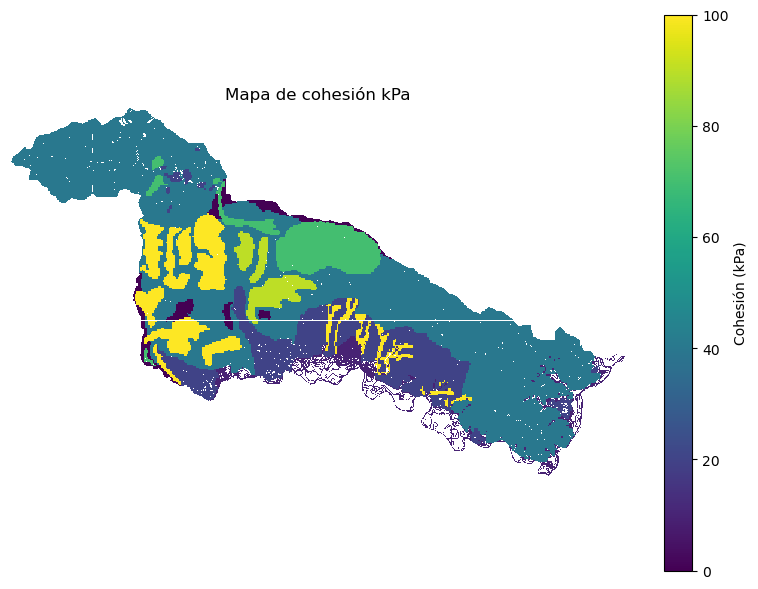

Valores únicos de cohesión asignados (kPa): [  0.  10.  20.  40.  70.  90. 100.]


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que geologia_masked y msk ya están definidos correctamente
# y que msk contiene 1 donde hay datos válidos y NaN donde no

# Diccionario actualizado de cohesión (kPa) por unidad geológica
c_values = {
    1: 10,   # Suelo transportado aluvial
    2: 100,  # Roca buena de tonalita
    3: 40,   # Suelo residual arcilloso (granodiorita)
    4: 40,   # Suelo residual areno-gravoso (granodiorita)
    5: 40,   # Suelo residual arcillo-limoso (granodiorita)
    6: 20,   # Suelo coluvial arcilloso
    7: 20,   # Suelo coluvial arcillo-limoso
    8: 10,   # Suelo antrópico
    9: 70,   # Roca mala de tonalita
    10: 90,  # Roca regular de tonalita
    11: 0,   # Suelo residual areno-gravoso (tonalita)
    12: 40,  # Suelo residual arcilloso (tonalita)
    13: 40,  # Suelo residual arcillo-limoso (tonalita)
    14: 70   # Roca mala de granodiorita
}

# Crear el mapa de cohesión inicialmente con np.nan
cohesion = np.full_like(geologia_masked, np.nan, dtype=float)

# Asignar valores de cohesión solo en donde la máscara es 1
for clase, valor in c_values.items():
    mascara_valida = (geologia_masked == clase) & (msk == 1)
    cohesion[mascara_valida] = valor

# Mostrar el resultado
plt.figure(figsize=(8, 6))
img = plt.imshow(cohesion, cmap='viridis', interpolation='none')
plt.colorbar(img, label='Cohesión (kPa)')
plt.title('Mapa de cohesión kPa')
plt.axis('off')
plt.tight_layout()
plt.show()

# Verificar los valores únicos
print("Valores únicos de cohesión asignados (kPa):", np.unique(cohesion[~np.isnan(cohesion)]))





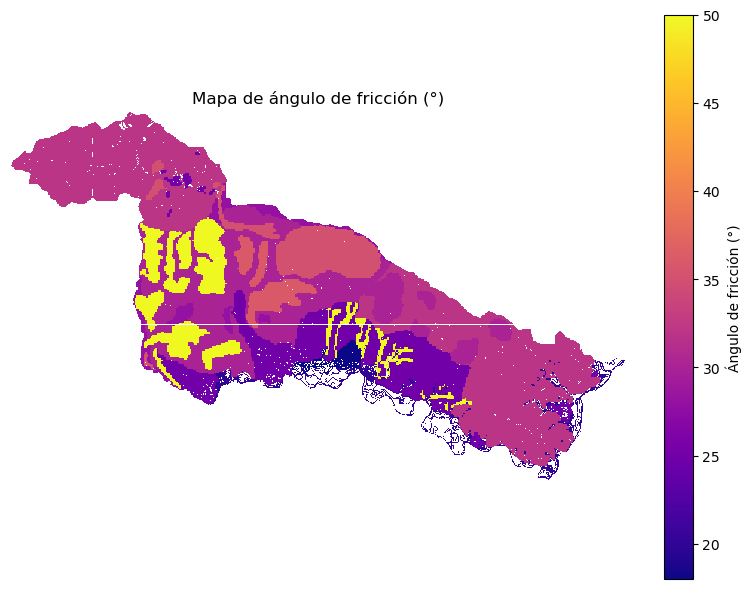

Valores únicos de fricción (°): [18. 20. 25. 28. 30. 32. 35. 36. 50.]


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que geologia_masked ya está definido

# Diccionario de ángulos de fricción (°) por unidad geológica
friccion_values = {
    1: 20,  # Suelo aluvial
    2: 50,  # Roca buena de tonalita
    3: 30,  # Suelo residual arcilloso (granodiorita)
    4: 32,  # Suelo residual areno-gravoso (granodiorita)
    5: 32,  # Suelo residual arcillo-limoso (granodiorita)
    6: 25,  # Suelo coluvial arcilloso
    7: 25,  # Suelo coluvial arcillo-limoso
    8: 18,  # Suelo antrópico
    9: 35,  # Roca mala de tonalita
    10: 36, # Roca regular de tonalita
    11: 28, # Suelo residual areno-gravoso (tonalita)
    12: 30, # Suelo residual arcilloso (tonalita)
    13: 30, # Suelo residual arcillo-limoso (tonalita)
    14: 35  # Roca mala de granodiorita
}

# Crear matriz base para el ángulo de fricción
friccion = np.full_like(geologia_masked, np.nan, dtype=float)

# Asignar valores de fricción según unidad
for unidad, angulo in friccion_values.items():
    friccion = np.where(geologia_masked == unidad, angulo, friccion)

# Visualizar el mapa
plt.figure(figsize=(8, 6))
img = plt.imshow(friccion, cmap='plasma', interpolation='none')
plt.title('Mapa de ángulo de fricción (°)')
plt.colorbar(img, label='Ángulo de fricción (°)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Mostrar valores únicos asignados
print('Valores únicos de fricción (°):', np.unique(friccion[~np.isnan(friccion)]))



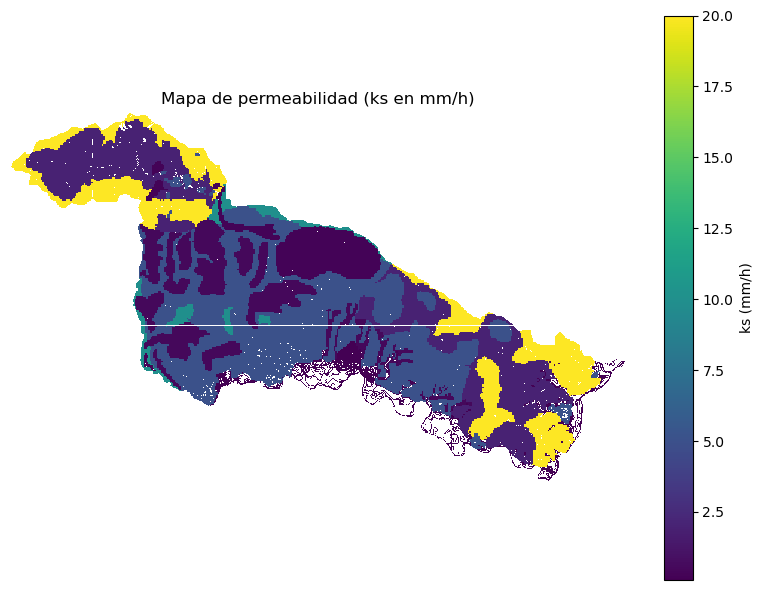

Valores únicos de permeabilidad (ks en mm/h): [ 0.1  0.3  0.5  2.   5.  10.  20. ]


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Suponemos que geologia_masked ya está definida (matriz de clases 1 a 14)

# Valores de conductividad hidráulica (ks) en mm/h según unidad geológica
k_values = {
    1: 0.1,   # Suelo aluvial: muy baja permeabilidad
    2: 0.5,   # Roca buena de tonalita: baja
    3: 5,     # Suelo residual arcilloso (granodiorita): moderada
    4: 20,    # Suelo residual areno-gravoso (granodiorita): media
    5: 2,     # Suelo residual arcillo-limoso (granodiorita): media-baja
    6: 5,     # Suelo coluvial arcilloso: moderada
    7: 5,     # Suelo coluvial arcillo-limoso: moderada
    8: 0.1,   # Suelo antrópico: muy baja
    9: 0.3,   # Roca mala de tonalita: baja
    10: 0.5,  # Roca regular de tonalita: baja
    11: 10,   # Suelo residual areno-gravoso (tonalita): moderada
    12: 5,    # Suelo residual arcilloso (tonalita): moderada
    13: 5,    # Suelo residual arcillo-limoso (tonalita): moderada
    14: 0.3   # Roca mala de granodiorita: baja
}

# Crear matriz de permeabilidad con NaN
permeabilidad = np.full_like(geologia_masked, np.nan, dtype=float)

# Asignar valor de ks a cada clase geológica
for unidad, ks_mm_h in k_values.items():
    permeabilidad = np.where(geologia_masked == unidad, ks_mm_h, permeabilidad)

# Visualizar los valores de permeabilidad directamente
plt.figure(figsize=(8, 6))
img = plt.imshow(permeabilidad, cmap='viridis', interpolation='none')
plt.title('Mapa de permeabilidad (ks en mm/h)')
cbar = plt.colorbar(img, label='ks (mm/h)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Mostrar los valores únicos asignados (en mm/h)
print('Valores únicos de permeabilidad (ks en mm/h):', np.unique(permeabilidad[~np.isnan(permeabilidad)]))



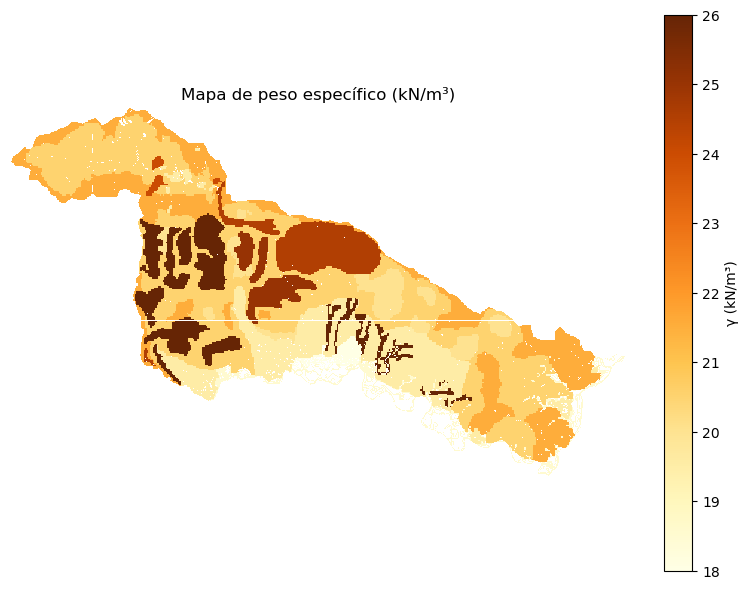

Valores únicos de peso específico (kN/m³): [18.  18.5 19.5 20.  20.5 21.5 24.  24.5 25.  26. ]


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Suponemos que geologia_masked ya está definido

# Diccionario de valores de peso específico (γ) en kN/m³ por unidad geológica
peso_esp_values = {
    1: 18.5,  # Suelo aluvial
    2: 26.0,  # Roca buena de tonalita
    3: 20.0,  # Suelo residual arcilloso (granodiorita)
    4: 21.5,  # Suelo residual areno-gravoso (granodiorita)
    5: 20.5,  # Suelo residual arcillo-limoso (granodiorita)
    6: 19.5,  # Suelo coluvial arcilloso
    7: 19.5,  # Suelo coluvial arcillo-limoso
    8: 18.0,  # Suelo antrópico
    9: 24.5,  # Roca mala de tonalita
    10: 25.0, # Roca regular de tonalita
    11: 21.5, # Suelo residual areno-gravoso (tonalita)
    12: 20.0, # Suelo residual arcilloso (tonalita)
    13: 20.5, # Suelo residual arcillo-limoso (tonalita)
    14: 24.0  # Roca mala de granodiorita
}

# Crear matriz base
peso_especifico = np.full_like(geologia_masked, np.nan, dtype=float)

# Asignar valores
for unidad, gamma in peso_esp_values.items():
    peso_especifico = np.where(geologia_masked == unidad, gamma, peso_especifico)

# Visualización
plt.figure(figsize=(8, 6))
img = plt.imshow(peso_especifico, cmap='YlOrBr', interpolation='none')
plt.title('Mapa de peso específico (kN/m³)')
plt.colorbar(img, label='γ (kN/m³)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Valores únicos asignados
print('Valores únicos de peso específico (kN/m³):', np.unique(peso_especifico[~np.isnan(peso_especifico)]))


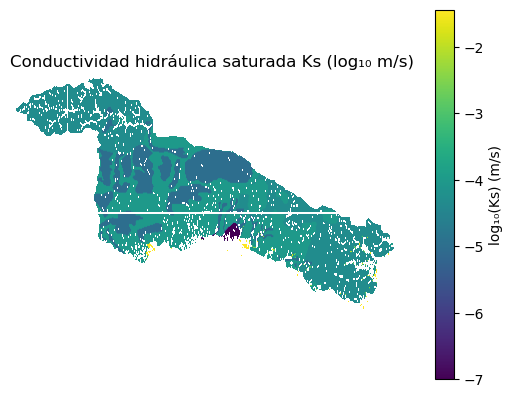

Valores únicos de Ks: [1.0e-07 1.0e-05 5.0e-05 1.0e-04 3.6e-02]


In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Crear base de Ks con el mismo tamaño que geologia_masked
ks = np.full_like(geologia_masked, np.nan, dtype=float)

# Asignar valores de Ks (m/s) según la unidad geológica
ks = np.where(geologia_masked == 1, 3.6e-2, ks)   # Aluvial
ks = np.where(geologia_masked == 2, 1e-5, ks)     # Roca buena tonalita
ks = np.where(geologia_masked == 3, 1e-4, ks)     # Suelo arcilloso (granodiorita)
ks = np.where(geologia_masked == 4, 5e-5, ks)     # Suelo areno-gravoso (granodiorita)
ks = np.where(geologia_masked == 5, 5e-5, ks)     # Suelo arcillo-limoso (granodiorita)
ks = np.where(geologia_masked == 6, 1e-4, ks)     # Suelo coluvial arcilloso
ks = np.where(geologia_masked == 7, 1e-4, ks)     # Suelo coluvial arcillo-limoso
ks = np.where(geologia_masked == 8, 1e-7, ks)     # Suelo antrópico
ks = np.where(geologia_masked == 9, 1e-5, ks)     # Roca mala tonalita
ks = np.where(geologia_masked == 10, 1e-5, ks)    # Roca regular tonalita
ks = np.where(geologia_masked == 11, 1e-4, ks)    # Suelo areno-gravoso (tonalita)
ks = np.where(geologia_masked == 12, 1e-4, ks)    # Suelo arcilloso (tonalita)
ks = np.where(geologia_masked == 13, 1e-4, ks)    # Suelo arcillo-limoso (tonalita)
ks = np.where(geologia_masked == 14, 1e-5, ks)    # Roca mala granodiorita

# Visualizar el mapa de Ks
plt.imshow(np.log10(ks), cmap='viridis')
plt.title('Conductividad hidráulica saturada Ks (log₁₀ m/s)')
plt.colorbar(label='log₁₀(Ks) (m/s)')
plt.axis('off')
plt.show()

# Ver los valores únicos asignados
print('Valores únicos de Ks:', np.unique(ks[~np.isnan(ks)]))


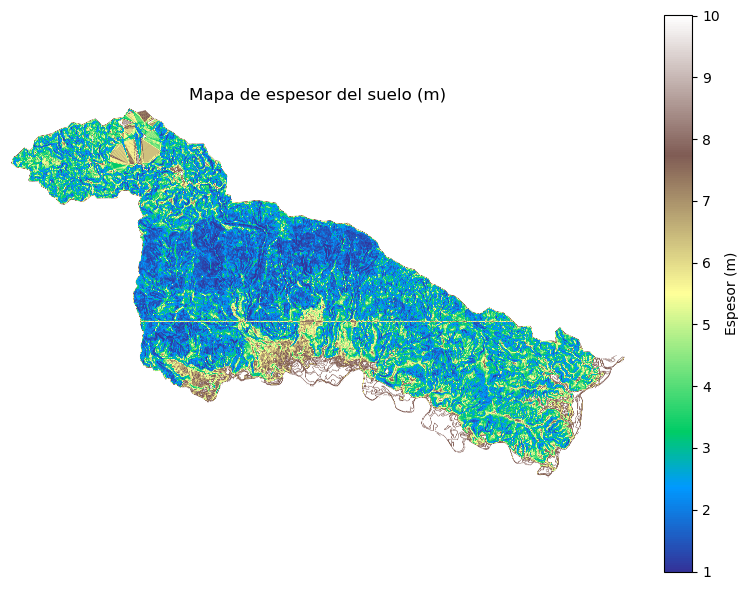

Espesor mínimo: 1.0
Espesor máximo: 10.0
Promedio: 7.662208


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Calcular espesor con fórmula empírica
espesor = 10 * np.exp(-0.05 * pendiente)

# Asignar np.nan donde la pendiente sea NaN
espesor = np.where(np.isnan(pendiente), np.nan, espesor)

# Limitar el espesor entre 1 m y 10 m
espesor = np.clip(espesor, 1, 10)

# Visualización
plt.figure(figsize=(8, 6))
plt.imshow(espesor, cmap='terrain')
plt.title('Mapa de espesor del suelo (m)')
plt.colorbar(label='Espesor (m)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Estadísticas útiles
print('Espesor mínimo:', np.nanmin(espesor))
print('Espesor máximo:', np.nanmax(espesor))
print('Promedio:', np.nanmean(espesor))






In [23]:
# Revisar zonas sin datos
print('NaNs en pendiente:', np.isnan(pendiente).sum())
print('NaNs en espesor:', np.isnan(espesor).sum())
print('NaNs en cohesion:', np.isnan(cohesion).sum())
print('NaNs en peso específico:', np.isnan(peso_especifico).sum())
print('NaNs en permeabilidad:', np.isnan(permeabilidad).sum())
print('NaNs en fricción:', np.isnan(friccion).sum())
print('NaNs en flujo:', np.isnan(flujo).sum())

NaNs en pendiente: 0
NaNs en espesor: 0
NaNs en cohesion: 69079110
NaNs en peso específico: 69079110
NaNs en permeabilidad: 69079110
NaNs en fricción: 69079110
NaNs en flujo: 0


In [24]:
GammaW   = 9.81 #peso unitario del agua [kN/m3]
dx = 1 # resolucion espacial del raster [m]
q = 100 #intensidad de la precipitacion [mm/h]

Mínimo: 0.0
Máximo: 89.926
NaNs: 0


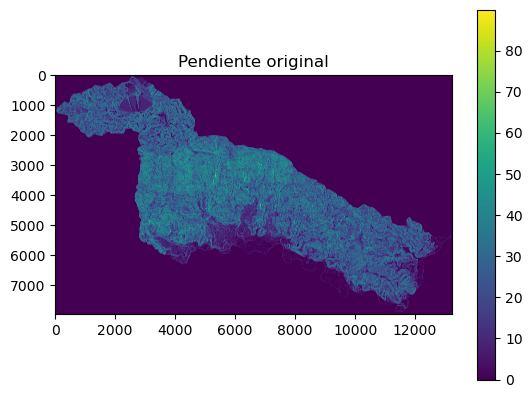

In [25]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

with rio.open(r'C:\Users\USUARIO\Desktop\Prueba\Lunes_noche\pendiente.tif') as src:
    pendiente = src.read(1)
    perfil = src.profile

print("Mínimo:", np.nanmin(pendiente))
print("Máximo:", np.nanmax(pendiente))
print("NaNs:", np.isnan(pendiente).sum())

plt.imshow(pendiente, cmap='viridis')
plt.colorbar()
plt.title("Pendiente original")
plt.show()

In [26]:
pendiente = np.radians(pendiente)  # Solo si está en grados


In [27]:
print("Mínimo:", np.nanmin(pendiente))
print("Máximo:", np.nanmax(pendiente))
print("NaNs:", np.isnan(pendiente).sum())

Mínimo: 0.0
Máximo: 1.5695049
NaNs: 0


In [28]:
import numpy as np

# Asegúrate de que tienes estas variables definidas: flujo, dx, ks, espesor, pendiente, friccion, cohesion, GammaW

# --- DEFINIR PESO ESPECÍFICO ---
peso = peso_especifico  # <--- Aquí se corrige el error

# --- Excluir celdas con flujo igual a 0 ---
flujo_seguro = np.where(flujo == 0, np.nan, flujo)

# --- Cálculo hidráulico M4 y M5 ---
M4 = flujo_seguro / dx

M5 = (
    (0.01 * ks * (espesor * np.cos(pendiente)) * np.sin(pendiente)) / (0.001 * q)
) * (
    (peso / GammaW) * (1 - np.tan(pendiente) / np.tan(np.radians(friccion)))
    + (cohesion / (GammaW * espesor * np.cos(pendiente)**2 * np.tan(np.radians(friccion))))
)

# --- Clasificación de estabilidad ---
MatEst = np.zeros_like(flujo)

MatEst1 = np.where(M4 > M5, 3, MatEst)   # Potencialmente inestable
MatEst2 = np.where(M4 <= M5, 4, MatEst1) # Potencialmente estable

# --- Evaluación con condiciones de estabilidad ---
M1 = np.tan(pendiente)
M2 = (1 - (GammaW / peso)) * np.tan(np.radians(friccion)) + (
    cohesion / (peso * espesor * np.cos(pendiente)**2)
)
MatEst3 = np.where(M1 < M2, 1, MatEst2)  # Incondicionalmente estable

M3 = np.tan(np.radians(friccion)) + (
    cohesion / (peso * espesor * np.cos(pendiente)**2)
)
MatEst4 = np.where(M1 >= M3, 2, MatEst3)  # Incondicionalmente inestable

# --- Asignar nan a valores no clasificados ---
MatEst = np.where(MatEst4 == 0, np.nan, MatEst4)

# --- Cálculo del valor de q crítico ---
Matq = (
    (1000 * 0.01 * ks * espesor * np.cos(pendiente) * np.sin(pendiente))
    * (dx / flujo_seguro)
    * (
        (peso / GammaW) * (1 - (np.tan(pendiente) / np.tan(np.radians(friccion))))
        + cohesion / (GammaW * espesor * np.cos(pendiente)**2 * np.tan(np.radians(friccion)))
    )
)

# --- Limpieza de inf y reasignación para clases extremas ---
Matq = np.where(np.isinf(Matq), np.nanmax(Matq[~np.isinf(Matq)]), Matq)
Matq = np.where(M1 < M2, -1, np.where(M1 >= M3, -2, Matq))



C:\Users\USUARIO\AppData\Local\Temp\ipykernel_21664\2976734764.py:53: RuntimeWarning: All-NaN slice encountered
  Matq = np.where(np.isinf(Matq), np.nanmax(Matq[~np.isinf(Matq)]), Matq)


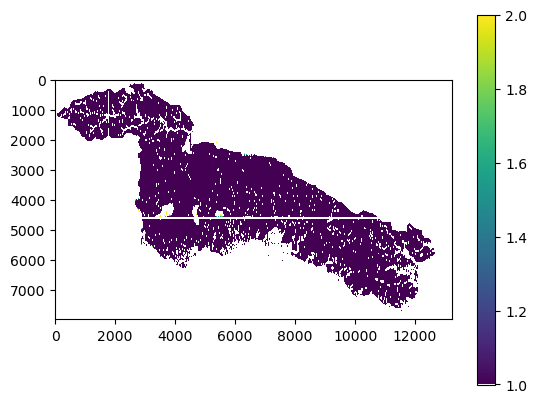

In [29]:
plt.imshow(MatEst)
plt.colorbar()

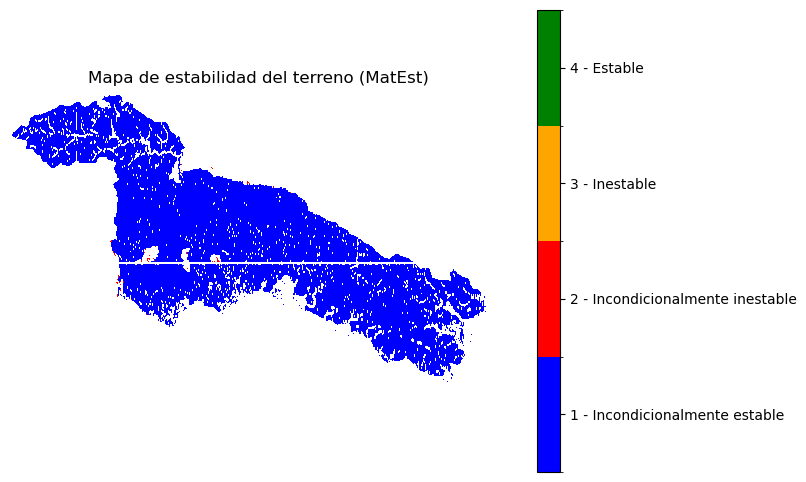

In [30]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Definir colores y etiquetas para cada clase de estabilidad
cmap_est = colors.ListedColormap(['blue', 'red', 'orange', 'green'])  # 1 a 4
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = colors.BoundaryNorm(bounds, cmap_est.N)

plt.figure(figsize=(8, 6))
plt.imshow(MatEst, cmap=cmap_est, norm=norm)
cbar = plt.colorbar(ticks=[1, 2, 3, 4])
cbar.ax.set_yticklabels([
    '1 - Incondicionalmente estable',
    '2 - Incondicionalmente inestable',
    '3 - Inestable',
    '4 - Estable'
])
plt.title('Mapa de estabilidad del terreno (MatEst)')
plt.axis('off')
plt.show()